<hr>

# UNET ARCHITECTURE AND IMPLEMENTATION

- Implemntation of U-NET architecture using Tensorflow Keras

<hr>

# IMPLEMENTATION

### Importing libraries and Loading the dataset

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import plot_model
from IPython.display import Image
import pprint

In [6]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

pprint.pprint(info, indent =3)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    spl

### Dataset preprocessing and preparation

- **Resizing** the images and masks to 128x128

In [50]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

   return input_image, input_mask

- **Augmentation** of the dataset
  - flipping them horizontally
  - data augmentation supplements the creation of data variations that can help a model improve the accuracy of its predictions.

In [8]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

- **Normalizing** the inputs for:
  - consistent input range
  - improved convergence
  - avoiding numerical instability

In [9]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

Loading training and testing images separately

In [10]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [11]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

print(len(train_dataset))
print(len(test_dataset))

3680
3669


### Defining the Model Architecture

In [12]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

- Function with layers ``Conv2D-ReLU-Conv2D-ReLU``, which we will use in both the encoder and the bottleneck of the U-Net.

In [13]:
def double_conv_block(x, n_filters):

   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

- Function for downsampling or feature extraction to be used in the encoder.

In [14]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

- Upsampling function for the decoder (or expanding path) of the U-Net

In [15]:
def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)       # upsample
   x = layers.concatenate([x, conv_features])                           # concatenate
   x = layers.Dropout(0.3)(x)                                           # dropout
   x = double_conv_block(x, n_filters)                                  # Conv2D twice with ReLU activation
   return x

### Building the U-NET model

In [16]:
def build_unet():
  inputs = layers.Input(shape=(128,128,3))

  f1, p1 = downsample_block(inputs, 64)
  f2, p2 = downsample_block(p1, 128)
  f3, p3 = downsample_block(p2, 256)
  f4, p4 = downsample_block(p3, 512)

  bottleneck = double_conv_block(p4, 1024)

  u6 = upsample_block(bottleneck, f4, 512)
  u7 = upsample_block(u6, f3, 256)
  u8 = upsample_block(u7, f2, 128)
  u9 = upsample_block(u8, f1, 64)

  outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

  unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

  return unet_model

- Model compilation and architecture

In [17]:
unet_model = build_unet()

unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

print(unet_model.summary())

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

- Visual representation of the model

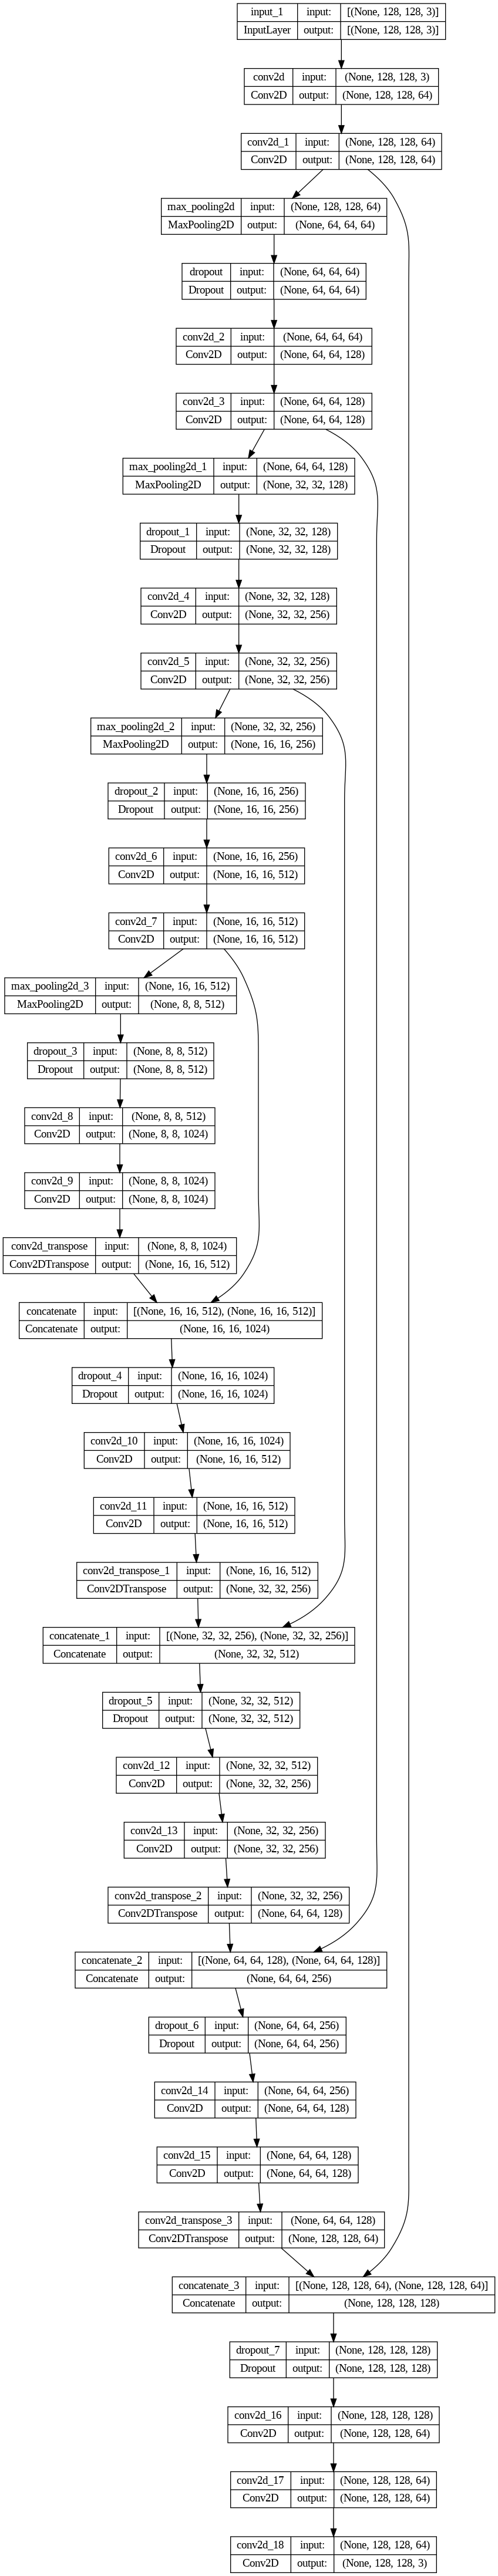

In [18]:
plot_model(unet_model, to_file='unet-model.png', show_shapes=True, show_layer_names=True, rankdir='TB')

### Model Training

In [19]:
NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/20
57/57 [==============================] - 129s 1s/step - loss: 0.9060 - accuracy: 0.5835 - val_loss: 0.8337 - val_accuracy: 0.5887
Epoch 2/20
57/57 [==============================] - 87s 1s/step - loss: 0.7328 - accuracy: 0.6739 - val_loss: 0.6611 - val_accuracy: 0.7269
Epoch 3/20
57/57 [==============================] - 64s 1s/step - loss: 0.6135 - accuracy: 0.7532 - val_loss: 0.5513 - val_accuracy: 0.7823
Epoch 4/20
57/57 [==============================] - 63s 1s/step - loss: 0.5553 - accuracy: 0.7807 - val_loss: 0.5130 - val_accuracy: 0.7997
Epoch 5/20
57/57 [==============================] - 64s 1s/step - loss: 0.5202 - accuracy: 0.7964 - val_loss: 0.4836 - val_accuracy: 0.8066
Epoch 6/20
57/57 [==============================] - 64s 1s/step - loss: 0.4603 - accuracy: 0.8221 - val_loss: 0.4262 - val_accuracy: 0.8350
Epoch 7/20
57/57 [==============================] - 64s 1s/step - loss: 0.4360 - accuracy: 0.8308 - val_loss: 0.4187 - val_accuracy: 0.8378
Epoch 8/20
57/57 [=

- Checking validation losses and accuracies

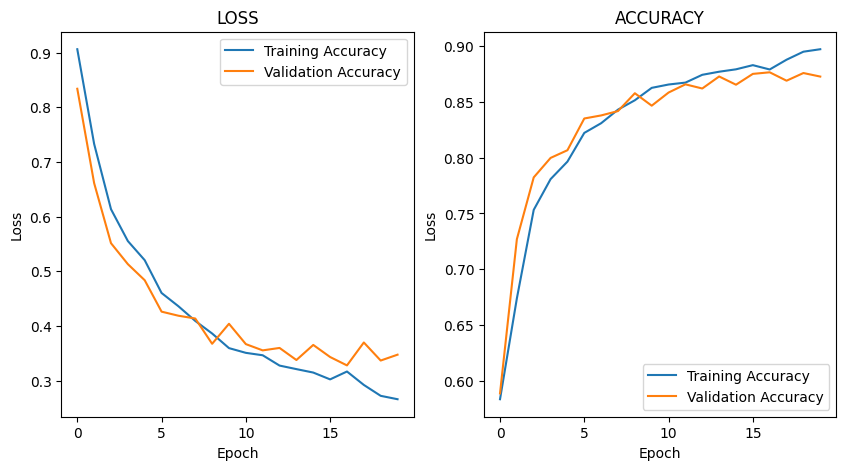

In [29]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LOSS')
plt.plot(model_history.history['loss'], label='Training Accuracy')
plt.plot(model_history.history['val_loss'], label='Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ACCURACY')
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

<hr>

# MODEL TESTING AND PREDICTIONS

- Selecting a random image from test dataset and predicting mask for it

In [45]:
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]

In [46]:
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]

In [47]:
def show_predictions(dataset=None, num=1):
 if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
 else:
   display([sample_image, sample_mask,
            create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 25ms/step


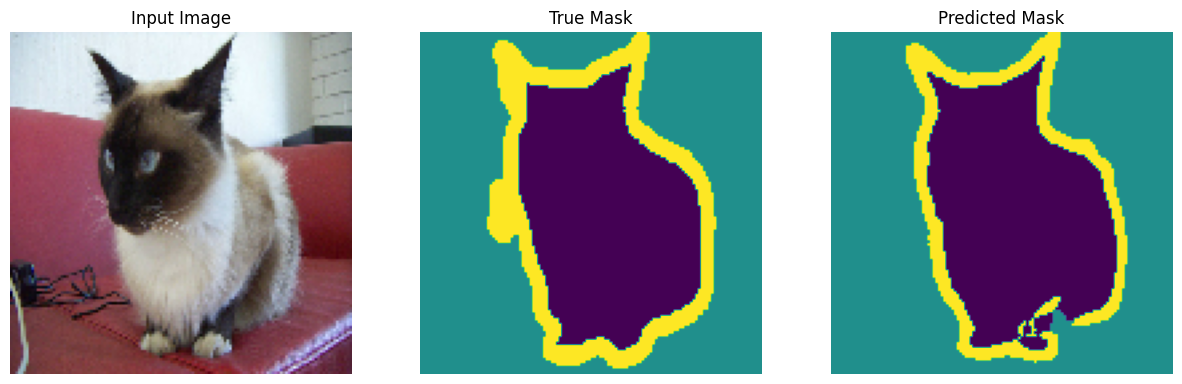

In [49]:
show_predictions(test_batches.skip(10))

<hr><hr>